# Tuning Formation Prediction
In this notebook we evaluated and tuned several models to predict offensive formation based on offensive starting position.

## Pipe Instantiation and Data Splitting
First, we instantiated the pipeline and chose only the columns relevent to offensive formation.

In [1]:
from pipeline import FullPipeWrapper

In [2]:
prep_pipe = FullPipeWrapper()

positional data already downloaded.
reading positional data.
returning positional data.


In [3]:
prep_pipe.extract_data_cols()

In [ ]:
data_off = prep_pipe.X_train[prep_pipe.off_form_cols]

We then selected the training data and the y variable as offensive formation.

In [ ]:
X_train = data_off.iloc[:, :-1]
y_train = data_off.iloc[:, -1]

We scaled the data to enable processing by a wider array of models.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Logistic Regression Tuning
The first model we looked at was a logistic regression model. This model had a reasonably high F1 macro score without tuning.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=10000)
cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1_macro')

array([0.73293543, 0.7521881 , 0.7887737 , 0.76713713, 0.78497895])

Next, we tuned the model using a variety of values for `C`.

In [51]:
from sklearn.model_selection import GridSearchCV

lr_params = {'C': [10**x for x in range(-4, 3)]}
lr_grid = GridSearchCV(log_reg, lr_params, cv=5, scoring='f1_macro')
lr_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='f1_macro')

The best score for our logistic regression model is fairly high.

In [52]:
lr_grid.best_score_

0.7721817317503302

In [114]:
from grid_result_plot import create_result_plot

Looking at the performance based on varying the `C` parameter, the best performance appears to be in the range given.

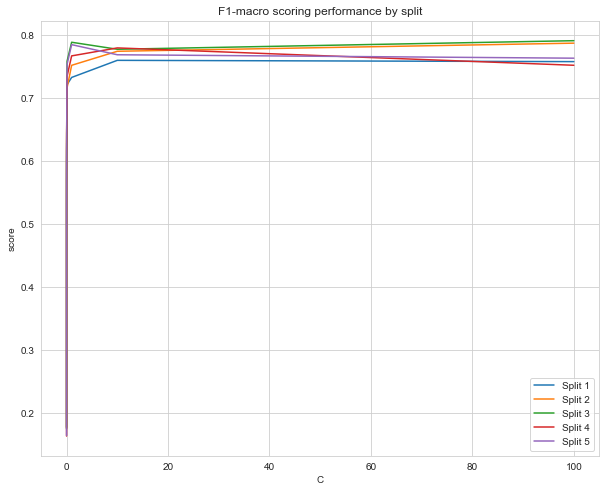

In [115]:
create_result_plot(lr_grid, 'C')

## Decision Tree Tuning
Next, we tuned a decision tree classifier. The untuned performance seems to be fairly good without tuning, and is in line with the initial performance of the logistic regression model.

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
dtree = DecisionTreeClassifier(random_state=0)
cross_val_score(dtree, X_train_scaled, y_train, scoring='f1_macro')

array([0.7106154 , 0.7767921 , 0.75767614, 0.78267896, 0.77267385])

We tested performance with two parameters, `min_samples_split` and `max_depth`.

In [58]:
params = {'min_samples_split': range(1, 5), 'max_depth': [None] + list(range(3, 10))}
dtree_grid = GridSearchCV(dtree, params, cv=5, scoring='f1_macro')
dtree_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': range(1, 5)},
             scoring='f1_macro')

The best score is lower than the best score for the logistic regression model.

In [68]:
dtree_grid.best_score_

0.7690694112676011

However, the performance appears to improve with higher `max_depth`.

In [4]:
create_result_plot(dtree_grid, 'max_depth')

NameError: name 'dtree_grid' is not defined

Performance does not appear to change drastically depending on the `min_samples_split` parameter.

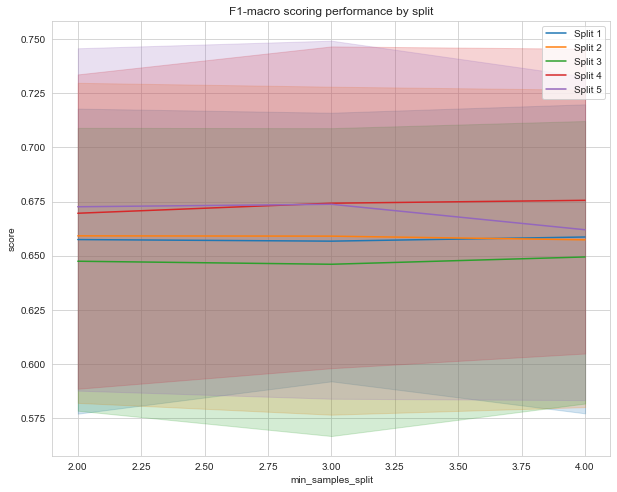

In [73]:
create_result_plot(dtree_grid, 'min_samples_split')

Next, we tested the performance using a higher range for `max_depth`.

In [77]:
dtree_params_2 = {'min_samples_split': range(1, 5), 'max_depth': range(9, 20)}
dtree_grid_2 = GridSearchCV(dtree, dtree_params_2, scoring='f1_macro')
dtree_grid_2.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(9, 20),
                         'min_samples_split': range(1, 5)},
             scoring='f1_macro')

The best score has improved drasitically while tuning this parameter.

In [78]:
dtree_grid_2.best_score_

0.786187329698693

It looks like the model is fully tuned on `max_depth`, as the performance does not improve at the edge of this chart.

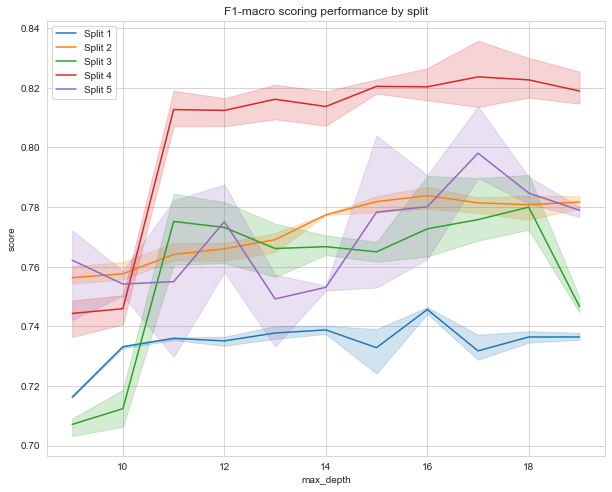

In [79]:
create_result_plot(dtree_grid_2, 'max_depth')

In [80]:
dtree_grid_2.best_params_

{'max_depth': 17, 'min_samples_split': 4}

## Random Forest Tuning
Next, we tuned a random forest model. The initial performance is better than for the other two models.

In [82]:
from sklearn.ensemble import RandomForestClassifier

rfor = RandomForestClassifier(random_state=0)
cross_val_score(rfor, X_train_scaled, y_train, scoring='f1_macro')

array([0.72469749, 0.81230823, 0.73040215, 0.81873203, 0.78838867])

We then used cross validation to test performance for a range of `max_depth` and `n_estimators`.

In [83]:
params_rfor = {'max_depth': [None] + list(range(3, 10)), 'n_estimators': [10**x for x in range(1, 4)]}
rfor_grid = GridSearchCV(rfor, params_rfor, cv=5, scoring='f1_macro')
rfor_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1_macro')

The best score is already higher than that for a fully tuned logistic regression model.

In [84]:
rfor_grid.best_score_

0.7812003070577187

Performance definitely seems to improve with an increase in `max_depth`.

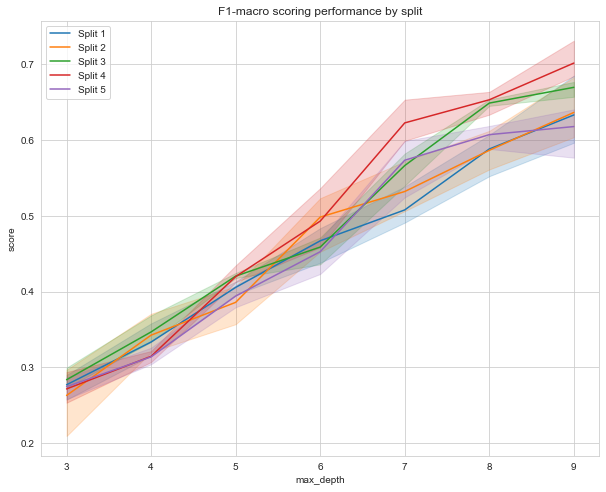

In [85]:
create_result_plot(rfor_grid, 'max_depth')

The ideal number of estimators looks to be in this range. So, we set the best value of the parameter found through grid search.

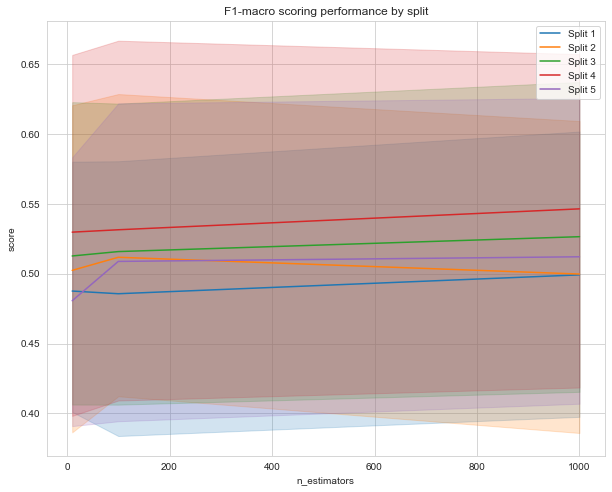

In [86]:
create_result_plot(rfor_grid, 'n_estimators')

In [88]:
rfor_grid.best_params_

{'max_depth': None, 'n_estimators': 1000}

Next, we looked at the effect of increasing the `max_depth`.

In [90]:
rfor2 = RandomForestClassifier(random_state=0, n_estimators=1000)
params_rfor2 = {'max_depth': range(9, 14)}
rfor_grid2 = GridSearchCV(rfor2, params_rfor2, cv=5, scoring='f1_macro')
rfor_grid2.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=0),
             param_grid={'max_depth': range(9, 14)}, scoring='f1_macro')

The performance is substantially worse, owing to the specification of `max_depth` when the default is `None`.

In [93]:
rfor_grid2.best_score_

0.752745242215756

However, it looks like the model continues to improve in performance with an increase in `max_depth`.

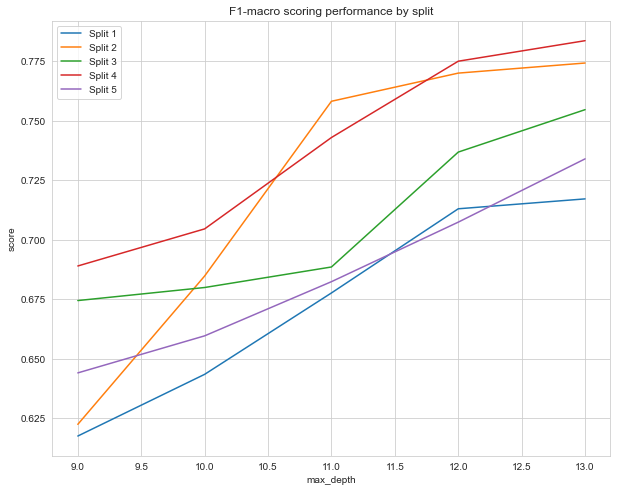

In [94]:
create_result_plot(rfor_grid2, "max_depth")

We next tested the performance with an increase again in `max_depth`.

In [95]:
params_rfor3 = {'max_depth': range(14, 20)}
rfor_grid3 = GridSearchCV(rfor2, params_rfor3, cv=5, scoring='f1_macro')
rfor_grid3.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=0),
             param_grid={'max_depth': range(14, 20)}, scoring='f1_macro')

The performance is still not at the same level as without tuning `max_depth`.

In [97]:
rfor_grid3.best_score_

0.7765570257359303

Additionally, it looks like we've tuned `max_depth` to its best performance.

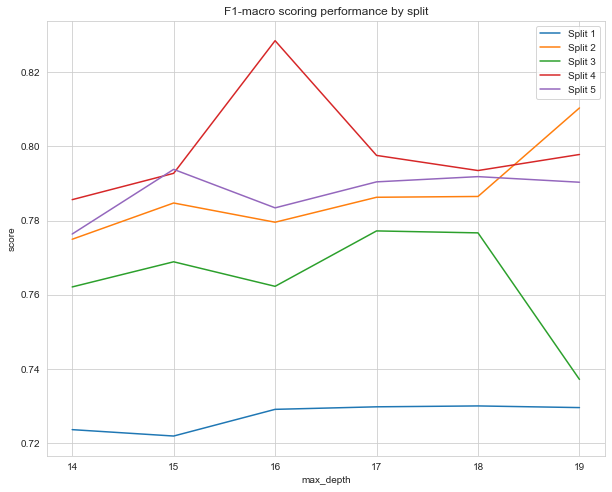

In [98]:
create_result_plot(rfor_grid3, "max_depth")

## Final Model Performance

The best score for any model was with the fully tuned decision tree. So, we chose this as our final model and tested its performance, first on the train set. The macro F1 score on the training set is extremely high, and the accuracy is near perfect.

In [103]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_train = dtree_grid_2.predict(X_train_scaled)
conf_mat_train = confusion_matrix(y_train, y_pred_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       EMPTY       0.99      1.00      0.99      1740
      I_FORM       0.99      0.91      0.95       643
       JUMBO       0.96      0.74      0.83        34
      PISTOL       0.99      0.65      0.79       158
     SHOTGUN       0.99      1.00      1.00      9236
  SINGLEBACK       0.97      1.00      0.98      2074
     WILDCAT       1.00      0.89      0.94        27

    accuracy                           0.99     13912
   macro avg       0.98      0.88      0.93     13912
weighted avg       0.99      0.99      0.99     13912



Finally, we used the test set to see how well the model generalizes to new data.

In [106]:
data_off_test = prep_pipe.X_test[prep_pipe.off_form_cols]
X_test = data_off_test.iloc[:, :-1]
y_test = data_off_test.iloc[:, -1]

In [107]:
X_test_scaled = scaler.transform(X_test)

In [108]:
y_pred = dtree_grid_2.predict(X_test_scaled)

The performance on the test set is again very good. The F1 scores are very high for every formation except Jumbo, which only had 6 supporting plays. The macro F1 score is very high, albeit lower than for the train set. The accuracy is also very high. It looks like our model has performed very well.

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       EMPTY       0.94      0.96      0.95       427
      I_FORM       0.92      0.86      0.89       160
       JUMBO       0.17      0.33      0.22         6
      PISTOL       0.89      0.68      0.77        47
     SHOTGUN       0.99      0.99      0.99      1999
  SINGLEBACK       0.97      0.98      0.97       422
     WILDCAT       1.00      1.00      1.00         1

    accuracy                           0.97      3062
   macro avg       0.84      0.83      0.83      3062
weighted avg       0.97      0.97      0.97      3062



In [110]:
print(confusion_matrix(y_test, y_pred))

[[ 412    0    0    3   12    0    0]
 [   0  137   10    0    2   11    0]
 [   0    4    2    0    0    0    0]
 [   4    0    0   32   10    1    0]
 [  19    0    0    1 1978    1    0]
 [   1    8    0    0    0  413    0]
 [   0    0    0    0    0    0    1]]


Finally, we saved the scaler and formation prediction model.

In [112]:
import pickle

with open("models/off_form.pkl", "wb") as off_form:
    pickle.dump(dtree_grid_2, off_form)

In [113]:
with open("models/off_scaler.pkl", "wb") as off_scaler:
    pickle.dump(scaler, off_scaler)